In [3]:
import pandas as pd
import nltk
import spacy
import warnings
warnings.filterwarnings('ignore')
from gensim.parsing.preprocessing import remove_stopwords
import process_mining
import nlp_mod

In [4]:
nltk.download('averaged_perceptron_tagger', quiet = True)
nltk.download('wordnet', quiet = True)
nltk.download('stopwords', quiet = True)
nltk.download('punkt', quiet = True)
pd.set_option('display.max_colwidth', 200)

In [5]:
#may need to add spacy download or python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [6]:
raw_data = pd.read_excel('C:/Users/chahb/Hackpions4/final_dataset.xlsx')

In [7]:
# unique step for extra column issue with provided dataset
cols_to_del = [x for x in raw_data.columns if x.startswith('Unnamed')]
raw_data.drop(columns = cols_to_del, inplace = True)
del cols_to_del

In [8]:
raw_data['Impacted application'].unique()

array(['Account eye ', 'Backup', 'Billing B', 'Chrome browser', 'Citrix',
       'Edge browser', 'Excel', 'Face reading application', 'Facebook',
       'Firefox browser', 'HR Saturn', 'LAN', 'Leave application',
       'Memory', 'Mozilla  browser', 'Power point', 'Printer',
       'Remote connect', 'Router', 'Scanner', 'Skype for Desktop',
       'Storage', 'Teams for Desktop', 'Ticketing application',
       'Time Sheet', 'Twitter', 'WAN', 'World'], dtype=object)

<AxesSubplot:>

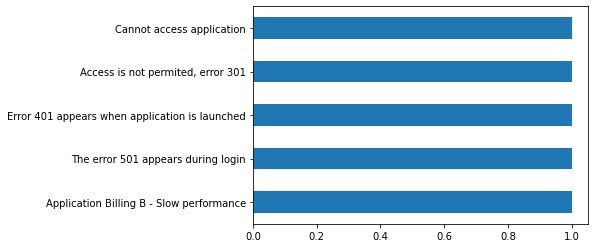

In [9]:
logs = process_mining.filter_affected_app_logs('Billing B',raw_data)[['Short Description','Work notes']] #will include SubClass
logs['Short Description'].value_counts().plot(kind = 'barh')

In [10]:
logs['Short Description'] = logs.apply(lambda s: nlp_mod.preprocess_text(s['Short Description']), axis = 1)    

In [11]:
for doc in logs['Short Description'].unique():
    print(doc)

application billing slow performance
401 appears application launched
cannot access application
access not permited 301
501 appears login


## Auto-Clustering test

In [12]:
i = 0
clusterFrame = raw_data[['Number', 'Impacted application', 'Short Description','Work notes']].head(25)

In [13]:
clusterFrame['SubClass'] = 'NO_MATCH'

In [14]:
#simulating the creation of incidents
# each iteration of the loop is a new incident

for i in range(clusterFrame.shape[0]):
    # check imacted application
    APP_NAME = clusterFrame['Impacted application'].iloc[i]

    # assign app problem subclass
    clusterFrame['SubClass'].iloc[i] = nlp_mod.assign_incident_subclass(clusterFrame['Short Description'].iloc[i], \
        clusterFrame[clusterFrame['Impacted application'] == APP_NAME].loc[0:(i-1)], APP_NAME)

    # display process graph
    
    # update process graph
        # only if the incident is resolved
clusterFrame.head()

,Number,Impacted application,Short Description,Work notes,SubClass
0,INC100032,Account eye,An error message appears when launching,23-03-2021 08:59:28 - Service Desk created the ticket (Work notes)\nAutomatic Assignment to Agent D in Service Desk team.\n\n23-03-2021 09:39:28 - Agent D (Work notes)\nUser can't logging to Acc...,Account eye _SubClass_1
1,INC100043,Account eye,There is an error message as soon the application is ran,05-05-2021 04:08:38- Service Desk created the ticket (Work notes)\nAssignment to Agent B in Service Desk team.\n\n05-05-2021 05:08:38- Agent B (Work notes)\nUser can't accessing to Application eye...,Account eye _SubClass_1
2,INC100023,Account eye,Users facing Slow performance issues while using account eye application,"11-01-2021 11:08:38 - Service Desk created the ticket (Work notes)\nAutomatic Assignment to Agent X in Service Desk team.\n\n11-01-2021 13:08:38 - Agent X (Work notes)\n""User is unable to access...",Account eye _SubClass_2
3,INC100004,Account eye,Users in Russia are unable to access the account eye application. Getting error 401,11-01-2021 11:08:38 - Service Desk created the ticket (Work notes)\nAutomatic Assignment to Agent D in Service Desk team.\n\n11-01-2021 12:08:38 - Agent D (Work notes)\nUser can't unable to acce...,Account eye _SubClass_3
4,INC100056,Backup,Backup process has an error at 34%,"02-07-2021 05:01:32 - Service Desk created the ticket (Work notes)\nAssignment to Agent C in Service Desk team.\n\n02-07-2021 05:11:32 - Agent C (Worknotes)\n""Backup is failing for the user.\n\n...",Backup_SubClass_1


In [15]:
clusterFrame[clusterFrame['SubClass'] == 'Backup_SubClass_3'][['Number','Short Description']]

,Number,Short Description
7,INC100018,Issue to acccess the shared drive
8,INC100078,"Shared drive is not accessible, error 302"
9,INC100112,Cannot access the shared drive (302)
10,INC100019,"Shared drive cannot be accessed, shows error 302"
11,INC100151,Shared drive not accessible for users in France
12,INC100063,Shared drive not opening for users
14,INC100150,Users in Panama encoutering Error 302 while opening Shared drive
15,INC100045,Users in Ukraine can't access shared drive


## Process Mining

In [16]:
process_data = []
logs = clusterFrame[clusterFrame['SubClass'] == 'Backup_SubClass_1'][['Number','Work notes']]
for idx in range(logs.shape[0]):
    process_data.extend(process_mining.preprocess_worknotes(logs.iloc[idx]))

In [17]:
process_data = pd.DataFrame(process_data, columns = ['Number','Timestamp','workNote'])

### Process Mining pipeline

* This section will generate the process flowchart for the worklogs as they come.
* This is just a proof of concept.
* Clustering is done one an issue class basis and then within the class it is done for the steps as listed in the worknotes.
* Common steps are custered into one group and replaced with the shortest string for presentability

In [18]:
demoData = pd.read_excel('demoData.xlsx')
cols_to_del = [x for x in demoData.columns if x.startswith('Unnamed')]
demoData.drop(columns = cols_to_del, inplace = True)

In [19]:
clusterFrame = demoData[['Number', 'Impacted application', 'Short Description','Work notes']]
clusterFrame['SubClass'] = 'NO_MATCH'

for i in range(clusterFrame.shape[0]):
    # check imacted application
    APP_NAME = clusterFrame['Impacted application'].iloc[i]

    # assign app problem subclass
    clusterFrame['SubClass'].iloc[i] = nlp_mod.assign_incident_subclass(clusterFrame['Short Description'].iloc[i], \
        clusterFrame[clusterFrame['Impacted application'] == APP_NAME].loc[0:(i-1)], APP_NAME)

    # display process graph
    
    # update process graph
        # only if the incident is resolved
clusterFrame.head()


,Number,Impacted application,Short Description,Work notes,SubClass
0,INC100032,Account eye,An error message appears when launching,23-03-2021 08:59:28 - Service Desk created the ticket (Work notes)\nAutomatic Assignment to Agent D in Service Desk team.\n\n23-03-2021 09:39:28 - Agent D (Work notes)\nUser reported he can't lo...,Account eye _SubClass_1
1,INC100056,Backup,Backup process has an error at 34%,02-07-2021 05:01:32 - Service Desk created the ticket (Work notes)\nAssignment to Agent C in Service Desk team.\n\n02-07-2021 05:11:32 - Agent C (Worknotes)\nUser reported backup is failing for ...,Backup_SubClass_1
2,INC100018,Backup,Issue to acccess the shared drive,16-02-2021 04:29:43 - Service Desk created the ticket (Work notes)\nAutomatic Assignment to Agent C in Service Desk team.\n\n16-02-2021 04:36:43 - Agent C (Worknotes)\nUser reported is unable to...,Backup_SubClass_2
3,INC100019,Backup,"Shared drive cannot be accessed, shows error 302",16-02-2021 04:29:43 - Service Desk created the ticket (Work notes)\nAutomatic Assignment to Agent John in Service Desk team.\n\n16-02-2021 05:29:43 - Agent John (Worknotes)\nUser reported she is...,Backup_SubClass_2
4,INC100151,Backup,Shared drive not accessible for users in France,04/08/21 03:55:27- Service Desk created the ticket (Work notes)\nAssignment to Agent John in Service Desk team.\n\n04/08/21 04:55:27- Agent John (Worknotes)\nUser reported is unable to access ...,Backup_SubClass_2


In [20]:
process_data = []
logs = clusterFrame[clusterFrame['SubClass'] == 'Backup_SubClass_1'][['Number','Work notes']]
for idx in range(logs.shape[0]):
    process_data.extend(process_mining.preprocess_worknotes(logs.iloc[idx]))

In [21]:
process_data = pd.DataFrame(process_data, columns = ['Number','Timestamp','workNote'])

In [22]:
process_data['workNote_type'] = process_data['workNote'].apply(lambda x: process_mining.classify_worknote(x))

In [23]:
types = ['Assignment','Automatic Assignment','Remarks','Request Info','Ask if','Response was','Take Action','Action outcome',\
            'Escalate to','User reported','Raise','Resolved','Resolution Note']
types = [x.lower() for x in types]
process_data['stepClass'] = 'NO_MATCH'

In [24]:
process_ = []
for type_ in types:
    sub_process = process_data[process_data['workNote_type'] == type_]
    process_.extend(nlp_mod.cluster_and_replace(sub_process))

process_ = pd.DataFrame(process_, columns = ['Number','Timestamp','workNote','workNote_type','stepClass'])
#process_.drop(columns = ['workNote_type'], inplace=True)

In [25]:
starts, ends = process_mining.draw_process_flow(process_, 'dot');